<b>
<p>
<center>
<font size="5">
The George Washington University
</font>
</center>
</p>
<b>
<p>
<center>
<img src="https://datasci.columbian.gwu.edu/sites/g/files/zaxdzs2996/f/image/Header_Data_Science.png"/>
<br>
<br>


<p>
<center>
<font size="3">
Machine Learning I - DATS 6202 11
</font>
</center>
</p>

<p>
<center>
<font size="4">
Fall 2020
</font>
</center>
</p>
    
<p>
<center>
<font size="3">
Final Project : Credit Card Fraud Detection
</font>
</center>
</p>

<p>
<center>
<font size="3">
Dr.Yuxiao Huang
</font>
</center>
</p>
</b>

<p>
<center>
<font size="3">
Abdulaziz Gebril, Mojahid Osman & Mina Hanna
</font>
</center>
</p>
</b>

<p>
<center>
<font size="3">
Using codes and techniques used in ML Class by Professor Yuxiao Huang <a href="https://github.com/minafawzi/teaching/tree/master/gwu/machine_learning_I/fall_2020/code">here</a>
</font>
</center>
</p>
</b>


# Overview

- This notebook includes final Machine Learning1 project.
- In this project we will be working on kaggle competition [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud).
- The goal of the project is to be explore the different techniques to handle credit card data and compare different model performance against this data.
-The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.


##Credit card fraud

According to <a href="https://www.prnewswire.com/news-releases/payment-card-fraud-losses-reach-27-85-billion-300963232.html">Nilson Report</a>, fraud losses in payment transcations reached \$27 billion dollars  in 2018 and expected to reach more than $40 billion in the next 10 years.


Credit card fraudulent transactions might be a result of one of the following:
 * **Account Takeover:** where a third party gain access to account infromation and user credentials to request a replacement credit or debit card
 * **Lost and stolen cards:** where card holders loses their card and a malicious third party make use of it
 * **Cloned card**: After databreaches some dark websites might be posting credit card information that can be used to clone a card that can be used in a fraudlent transaction

In general, card fraud is measured by losses per $100 of total sales as per the following image from Nilson Report:

<br>
<img src="https://mma.prnewswire.com/media/1033871/The_Nilson_Report.jpg?p=publish&w=650"/>

##The data challenge

The nature of the card payment transaction and its attributes impose some challenges to have a standardized approach to build a fraud detection system. Some of these challenges are explained in the following list:

* **Data irregularity:** As highlighted in the provious section, credit card transactions data are highliy imbalanced because only a very few fraction of the transactions are fraudelent 
* **Secure nature of the data:** The credit card data and other attributes has to follow different security regulations with regards to confidentiality and privacy which restrict the sharing of the data between multiple inistitutions 
* **Precision and recall impact:** The criteria of model selection has to consider the high impact of false negative compared to false positive classification
* **Commercial aspects and user experience:** Since the majority of credit card transaction are not of a very high dollar value, the cost of prevention and the impact to the user experience in terms of speed has to considered when processing the data and defining the best model

# Notebook Configuration

## Google drive

Mount google drive with data and other utilities

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/homework/Project/'


# Get the absolute path of the shallow utilities folder
abspath_util_shallow = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/code/utilities/p2_shallow_learning/'

# Get the absolute path of the shallow models folder
abspath_model_shallow = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/code/models/p2_shallow_learning/'

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import matplotlib.gridspec as gridspec
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

## Warning

In [ ]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Matplotlib

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

## TensorFlow

In [ ]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 

import tensorflow as tf
from tensorflow import keras

## Random seed

In [ ]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

# Data Preprocessing
Note: You will need to specify the date time variables, *datetime_vars*, when handling date time variables.

In [ ]:
# Change working directory to the absolute path of the shallow utilities folder
%cd $abspath_util_shallow

# Import the shallow utitilities
%run pmlm_utilities_shallow.ipynb
%run pmlm_models_shallow.ipynb

/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/code/utilities/p2_shallow_learning


## Useful functions

Useful functions from <a href="https://github.com/minafawzi/teaching/tree/master/gwu/machine_learning_I/fall_2020/code">here</a>

In [ ]:
from sklearn.manifold import TSNE
import os

def plot_scatter_tsne(X, y, classes, labels, colors, markers, loc, dir_name, fig_name, random_seed):
    """
    Plot the scatter plot using TSNE
    
    Parameters
    ----------
    X : the feature matrix
    y : the target vector
    classes : the classes in the target vector
    labels : the labels for different classes
    colors : the colors for different classes
    markers : the markers for different classes
    loc : the location of the legend
    dir_name : the name of the directory
    fig_name : the name of the figure
    random_seed : the random seed
    """
    
    # Make directory
    directory = os.path.dirname(dir_name)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Get the tsne transformed training feature matrix
    X_embedded = TSNE(n_components=2, random_state=random_seed).fit_transform(X)

    # Get the tsne dataframe
    tsne_df = pd.DataFrame(np.column_stack((X_embedded, y)), columns=['x1', 'x2', 'y'])

    # Get the data
    data = {}
    for class_ in classes:
        data_x1 = [tsne_df['x1'][i] for i in range(len(tsne_df['y'])) if tsne_df['y'][i] == class_]
        data_x2 = [tsne_df['x2'][i] for i in range(len(tsne_df['y'])) if tsne_df['y'][i] == class_]
        data[class_] = [data_x1, data_x2]
    
    # The scatter plot
    fig = plt.figure(figsize=(8, 6))
    
    for class_, label, color, marker in zip(classes, labels, colors, markers):
        data_x1, data_x2 = data[class_]
        plt.scatter(data_x1, data_x2, c=color, marker=marker, s=120, label=label)

    # Set x-axis
    plt.xlabel('x1')

    # Set y-axis
    plt.ylabel('x2')

    # Set legend
    plt.legend(loc=loc)

    # Save and show the figure
    plt.tight_layout()
    plt.savefig(dir_name + fig_name)
    plt.show()

In [ ]:
from sklearn.model_selection import PredefinedSplit

def get_train_val_ps(X_train, y_train, X_val, y_val):
    """
    Get the:
    feature matrix and target velctor in the combined training and validation data
    target vector in the combined training and validation data
    PredefinedSplit
    
    Parameters
    ----------
    X_train : the feature matrix in the training data
    y_train : the target vector in the training data
    X_val : the feature matrix in the validation data
    y_val : the target vector in the validation data  

    Return
    ----------
    The feature matrix in the combined training and validation data
    The target vector in the combined training and validation data
    PredefinedSplit
    """  

    # Combine the feature matrix in the training and validation data
    X_train_val = np.vstack((X_train, X_val))

    # Combine the target vector in the training and validation data
    y_train_val = np.vstack((y_train.reshape(-1, 1), y_val.reshape(-1, 1))).reshape(-1)

    # Get the indices of training and validation data
    train_val_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_val.shape[0], 0))

    # The PredefinedSplit
    ps = PredefinedSplit(train_val_idxs)

    return X_train_val, y_train_val, ps

In [ ]:
def nan_checker(df):
    """
    The NaN checker

    Parameters
    ----------
    df : the dataframe
    
    Returns
    ----------
    The dataframe of variables with NaN, their proportion of NaN and data type
    """
    
    # Get the dataframe of variables with NaN, their proportion of NaN and data type
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False).reset_index(drop=True)
    
    return df_nan


In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Loading the data

In the project we will use the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [ ]:
import pandas as pd
# Load data
df = pd.read_csv(abspath_curr+'/data/credit_card_fraud_detection/creditcard.csv')
df.head()


# Load the raw training data
#df_raw_train = pd.read_csv(abspath_curr + 'data/credit_card_fraud_detection/train.csv',
                           #header=0)
# Make a copy of df_raw_train
#df_train = df_raw_train.copy(deep=True)

# Load the raw test data
#df_raw_test = pd.read_csv(abspath_curr + 'data/credit_card_fraud_detection/test.csv',
                          #header=0)
# Make a copy of df_raw_test
#df_test = df_raw_test.copy(deep=True)

# Get the name of the target
#target = 'trip_duration'

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#Checking for missing values
df_nan = nan_checker(df)
df_nan

,var,proportion,dtype


## Class Distribution

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

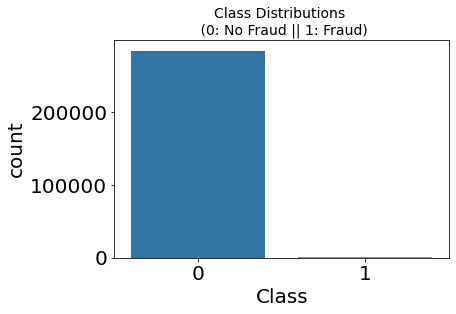

In [ ]:
#plotting the class Distribution
sns.countplot('Class', data=df,)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

As illustrated by the above diagram, the data is imbalanced where the transactions labeled as fraud are far less than legit transactions.

While this reflect the real world scenario, it will require further processing before usage for any machine learning model.

## EDA 

Only transaction time and transaction amount are known features while all other features are not because the dataset is a result of a Principle Component Analysis (PCA) reduction.


## Plotting known features
The following section plots the two known variables (Transcation Amount and time).

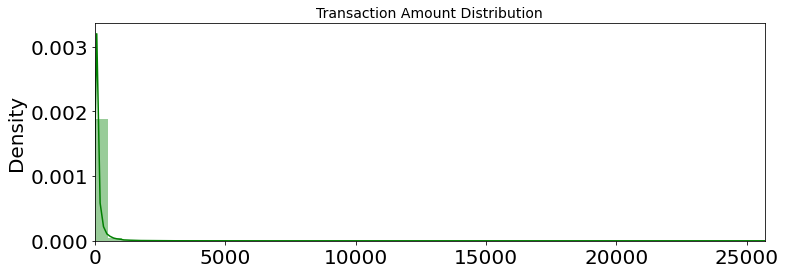

In [ ]:
#Plotting the distribution of "Amount" and "Time"
fig, ax = plt.subplots(1, 1, figsize=(12,4))

amount= df['Amount'].values
time= df['Time'].values

sns.distplot(amount, ax=ax, color="g")
ax.set_title('Transaction Amount Distribution', fontsize=14)
ax.set_xlim([min(amount), max(amount)])



plt.show()


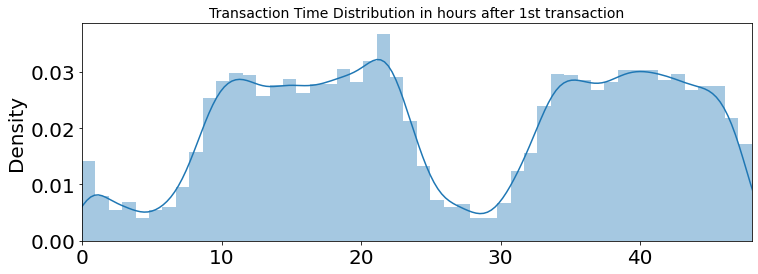

In [ ]:
#Plotting the distribution of "Amount" and "Time"
fig, ax = plt.subplots(1, 1, figsize=(12,4))

time= df['Time'].values/3600

sns.distplot(time, ax=ax)
ax.set_title('Transaction Time Distribution in hours after 1st transaction', fontsize=14)
ax.set_xlim([min(time), max(time)])

plt.show()

As described by the dataset sources, the transactions were captured over 2 days (48 hours) which can be explained bt the distrribution of time where day and night transaction traffic is obvious.

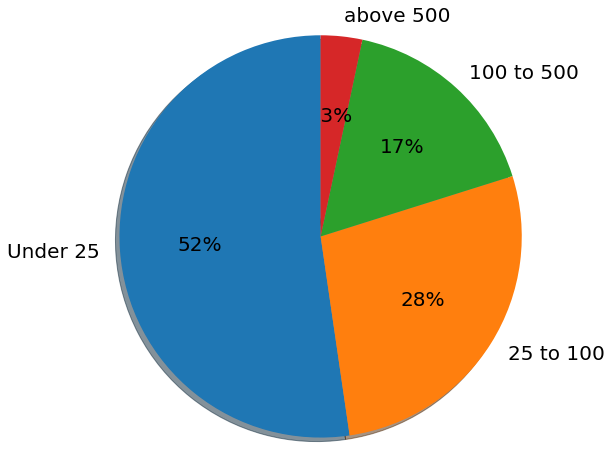

In [ ]:

fig1, ax1 = plt.subplots(1, 1, figsize=(8,8))

amount= df['Amount'].values
amount_under_25 = amount[amount[:]<25]
amount_btw_25_100 = amount[(amount >= 25) & (amount < 100)]
amount_btw_100_500 = amount[(amount >= 100) & (amount < 500)]
amount_above_500 = amount[(amount >= 500)]

data = [len(amount_under_25), len(amount_btw_25_100),len(amount_btw_100_500),len(amount_above_500)]
explode = (0, 0, 0, 0) 
labels = ["Under 25", "25 to 100","100 to 500","above 500"]


ax1.pie(data, explode=explode, labels=labels, autopct='%2.0f%%',
        shadow=True, startangle=90)


ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


#data
#plt.boxplot(amount) 
#plt.show() 

Card transaction amount distribution shows that more than half of the transactions are under 25 Euros while transactions above 500 Euros are less than 3%.

## Plotting all features distributions

The plots below represent the classes distribution for all PCA compnents. The fraud transactions and non-fraud transactions are represnted by the orange and blue colors respectively. It can be noticed that both types of transactions follow the same distributions for some features such as V6,V7, V8, V13, V15 and V21 to V28. Other features such as V11, V12 and V14 have different distrubtions.

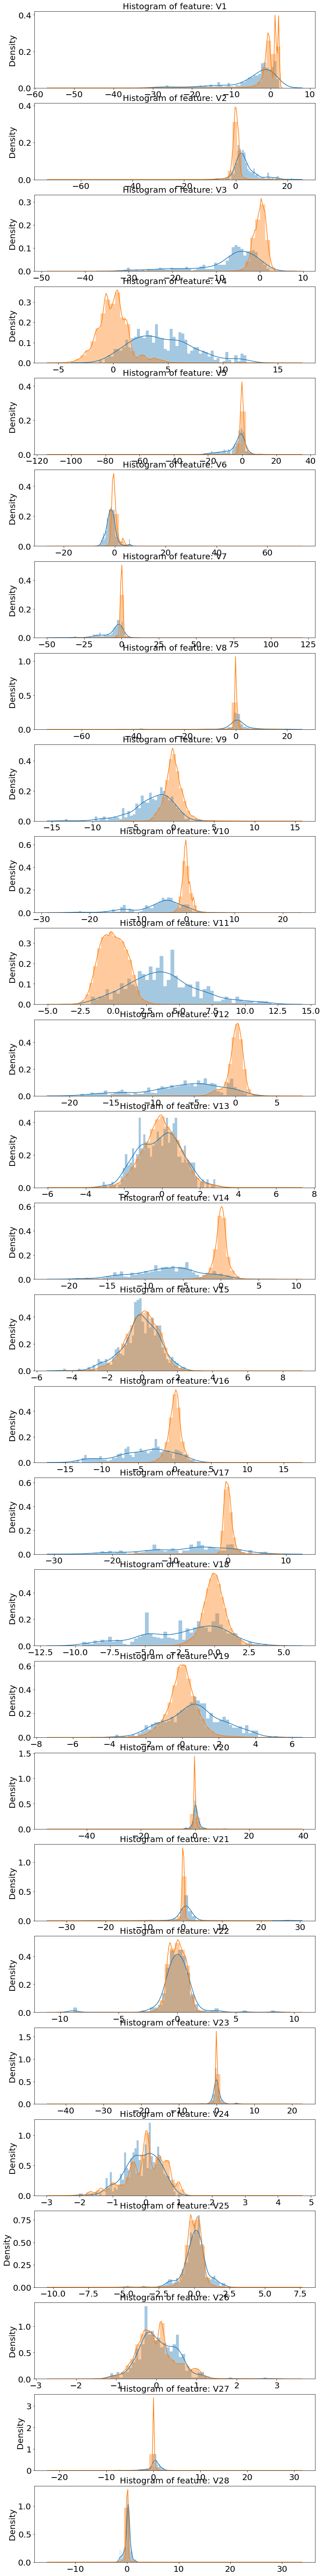

In [ ]:
#Plotting the classes distribution for all PCA component features

v_features =['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Histogram of feature: ' + str(cn))
plt.show()

## Splitting the Data



Splitting the data is taking place before any processing (i.e. undersampling, scaling) to maintain the abstraction between any training and testing data.
Since the data is highly imbalanced, the stratified split is selected to maintain the class distribution after the split

### Split Train and Test data

In [ ]:
#df =  df.drop(['Time'], axis=1)


from sklearn.model_selection import StratifiedShuffleSplit


print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']
#using StratifiedKfold to generate (Train dataframe and  Test dataframe ) having the same class distribution that is similar to the orginial data

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    


# Verify the Distribution of the labels


# Turn into an array
original_Xtrain_array = original_Xtrain.values
original_Xtest_array = original_Xtest.values
original_ytrain_array = original_ytrain.values
original_ytest_array = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain_array, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest_array, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain_array))
print(test_counts_label/ len(original_ytest_array))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [ ]:
original_Xtrain.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [ ]:
original_ytrain.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [ ]:
# Print the dimension of training features dataframe
pd.DataFrame([[original_Xtrain.shape[0], original_Xtrain.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,227846,30


In [ ]:
# Print the dimension of validation features dataframe
#pd.DataFrame([[data_validation.shape[0], data_validation.shape[1]]], columns=['# rows', '# columns'])

In [ ]:
# Print the dimension of testing features dataframe
pd.DataFrame([[original_Xtest.shape[0], original_Xtest.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,56961,30


In [ ]:
# Print the dimension of train target dataframe
original_ytrain=pd.DataFrame(original_ytrain)
pd.DataFrame([[original_ytrain.shape[0], original_ytrain.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,227846,1


In [ ]:
# Print the dimension of validation target dataframe
#y_validation=pd.DataFrame(y_validation)
#pd.DataFrame([[y_validation.shape[0], y_validation.shape[1]]], columns=['# rows', '# columns'])

In [ ]:
# Print the dimension of testing target dataframe
original_ytest=pd.DataFrame(original_ytest)
pd.DataFrame([[original_ytest.shape[0], original_ytest.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,56961,1


### Convert time to a categorical field

Since the transactions were done thru two consecutive days, we will split the data to reflect peak and offpeak which will reflect day or night timing of the transaction.
The current time field might not be effective so the idea is to extract the peak feature and validate if this will achieve any progress.
This is done at the end of the report.

In [ ]:
original_Xtest.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
212516,138894.0,-1.298443,1.948100,-4.509947,1.305805,-0.019486,-0.509238,-2.643398,1.283545,-2.515356,-4.501315,2.093075,-5.418889,-1.247014,-3.828268,0.399050,-6.366500,-7.550968,-4.902767,0.152892,0.250415,1.178032,1.360989,-0.272013,-0.325948,0.290703,0.841295,0.643094,0.201156,0.01
212644,138942.0,-2.356348,1.746360,-6.374624,1.772205,-3.439294,1.457811,-0.362577,1.443791,-1.927359,-6.564659,2.450752,-5.694074,-1.155469,-7.132151,-0.059628,-4.596577,-5.522088,-3.529066,-0.663371,0.194810,0.857942,0.621203,0.964817,-0.619437,-1.732613,0.108361,1.130828,0.415703,727.91
213092,139107.0,-4.666500,-3.952320,0.206094,5.153525,5.229469,0.939040,-0.635033,-0.704506,-0.234786,4.031435,0.983647,-0.578914,-0.199814,-0.729707,1.266713,-0.842769,-0.102946,-0.597597,1.060154,-2.286137,-0.664263,1.821422,0.113563,-0.759673,-0.502304,0.630639,-0.513880,0.729526,22.47
213116,139117.0,-3.975939,-1.244939,-3.707414,4.544772,4.050676,-3.407679,-5.063118,1.007042,-3.190158,-4.250717,4.182162,-4.563675,1.182503,-6.964972,1.115340,-4.997332,-6.419539,-1.183593,3.569733,2.109403,1.059737,-0.037395,0.348707,-0.162929,0.410531,-0.123612,0.877424,0.667568,8.30
214662,139767.0,0.467992,1.100118,-5.607145,2.204714,-0.578539,-0.174200,-3.454201,1.102823,-1.065016,-5.416037,4.497929,-5.019610,-1.019691,-7.914989,0.669648,-4.472014,-5.856998,-2.243178,-0.173814,0.589575,0.983481,0.899876,-0.285103,-1.929717,0.319869,0.170636,0.851798,0.372098,120.54


In [ ]:
original_Xtrain_withpeak = original_Xtrain.copy()
original_Xtrain_withpeak['Peak'] = np.where(original_Xtrain_withpeak['Time']/3600 <24, np.where(original_Xtrain_withpeak['Time']/3600<8 ,0 , 1), np.where(original_Xtrain_withpeak['Time']/7200<8 ,0 , 1))

original_Xtest_peak = original_Xtest.copy()
original_Xtest_peak['Peak'] = np.where(original_Xtest_peak['Time']/3600 <24, np.where(original_Xtest_peak['Time']/3600<8 ,0 , 1), np.where(original_Xtest_peak['Time']/7200<8 ,0 , 1))


In [ ]:
original_Xtrain_withpeak.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Peak
227864,145259.0,-1.329248,2.057312,0.417536,3.259226,2.031582,5.808571,-1.966416,-0.780131,-2.361387,0.690474,-0.529497,-0.312278,-0.112675,0.849992,1.284371,0.382492,0.318950,0.090363,0.940716,0.962591,-1.447473,-0.254170,0.172166,0.624782,-0.092178,0.215728,0.223553,0.132879,0.76,1
227865,145259.0,2.036041,0.259237,-1.771522,0.458296,0.584333,-0.820823,0.305824,-0.271230,0.549965,-0.648271,-0.304627,0.758272,0.932677,-1.095190,0.293868,0.011492,0.578979,-0.249355,-0.023326,-0.113310,-0.317084,-0.740493,0.283709,0.488747,-0.063826,-0.610194,0.007487,-0.013918,9.99,1
227866,145260.0,-1.246150,0.863064,0.478690,0.405342,0.203485,0.168488,-0.136939,0.682942,-2.009559,-0.477580,1.106494,0.186052,0.610691,-1.886214,0.064684,-0.880418,1.710821,2.989243,-0.277785,-0.013211,-0.319465,-0.588918,-0.186107,0.468036,0.571794,-0.403076,0.259078,0.077267,56.00,1
227867,145260.0,-0.110603,0.858057,-1.273800,0.001574,2.404707,3.848640,-0.268571,1.300495,-0.729043,-0.268449,-0.104774,0.151986,-0.054262,0.989084,1.759255,-1.413539,0.752186,-0.221631,2.769259,0.165291,-0.089540,-0.301653,0.125633,0.700880,-0.769575,-0.193723,0.143983,0.134559,9.99,1
227868,145260.0,-0.413328,1.301241,1.451162,4.465927,-0.083834,1.362130,-0.438776,0.779888,-1.568128,1.139381,-1.659785,-0.882778,-0.129257,0.225318,0.756051,0.212962,0.245408,0.696003,0.947055,0.133876,0.386092,1.043509,-0.021812,0.609969,-0.695184,0.463574,0.119990,0.134411,30.26,1


## Scaling the data

Standardlization is only performed on "Amount" and "Time" features, since the other features are obtained through PCA and were already scaled.

In [ ]:
#Scaling time and amount
# The StandardScaler

ss = StandardScaler()

#Scaling the training_data
original_Xtrain["Amount"]= ss.fit_transform(original_Xtrain["Amount"].values.reshape(-1,1))
original_Xtrain["Time"]= ss.fit_transform(original_Xtrain["Time"].values.reshape(-1,1))

#Scaling the validation_data
#data_validation["Amount"]= ss.fit_transform(data_validation["Amount"].values.reshape(-1,1))
#data_validation["Time"]= ss.fit_transform(data_validation["Time"].values.reshape(-1,1))

#Scaling the testing_data
original_Xtest["Amount"]= ss.fit_transform(original_Xtest["Amount"].values.reshape(-1,1))
original_Xtest["Time"]= ss.fit_transform(original_Xtest["Time"].values.reshape(-1,1))



# Undersampling

In this section, we will try to deal with the highly imbalanced data using undersampling. This will be established by decreasing the number of non-fraud transactions to have a new dataframe of evenly distributed classes.

In [ ]:
# Finding the number of fraud classes in the main dataframe
len(df.loc[df['Class'] == 1])

492

In [ ]:
# Shuffling the data to ceate a normally distributed dataframe
df = df.sample(frac=1)

# number  of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_dist_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
underSample_df = normal_dist_df.sample(frac=1, random_state=random_seed)

underSample_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
146884,87941.0,2.054361,-0.122642,-1.245717,0.189567,0.132497,-0.620765,0.059581,-0.148058,0.338940,0.247959,0.504313,0.884524,-0.098371,0.475306,-0.608077,0.237496,-0.702700,-0.199364,0.616409,-0.209856,-0.271204,-0.687048,0.271569,-0.497120,-0.270115,0.208619,-0.076075,-0.075428,0.99,0
95597,65385.0,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,-1.016592,-4.320536,1.277202,-3.701750,-0.971870,-4.857777,0.090606,-2.801502,-4.186808,-1.648406,1.176446,-0.447039,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1354.25,1
96768,65927.0,0.955253,-0.833374,0.847147,0.725970,-1.322868,-0.238842,-0.565347,0.022443,-0.762247,0.738315,-0.223308,-0.136965,-0.030759,0.119714,1.356862,-1.397447,0.065630,1.061450,-1.912073,-0.294785,-0.110554,-0.129397,-0.040892,0.364872,0.204756,-0.304578,0.055908,0.062489,156.00,0
75511,56098.0,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,-3.245109,2.338323,-2.820042,0.763326,-5.419590,0.041433,-4.180758,-4.285071,-2.536452,0.930239,0.270459,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,170.92,1
255556,157284.0,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,-4.128505,-3.963224,4.469467,-4.655071,-0.441776,-10.149813,0.612798,-0.288725,1.404507,2.132081,0.707200,0.562030,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,0.77,1


Distribution of the Classes in the undersampled dataset
1    0.5
0    0.5
Name: Class, dtype: float64


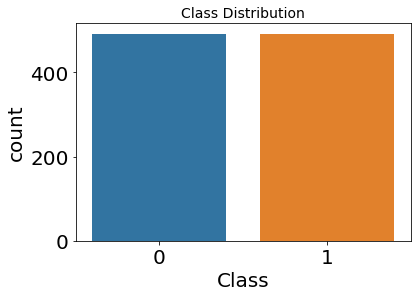

In [ ]:
print('Distribution of the Classes in the undersampled dataset')
print(underSample_df['Class'].value_counts()/len(underSample_df))



sns.countplot('Class', data=underSample_df)
plt.title('Class Distribution', fontsize=14)
plt.show()


The following plot shows class distribution amoung selected features after undersampling of the majority class

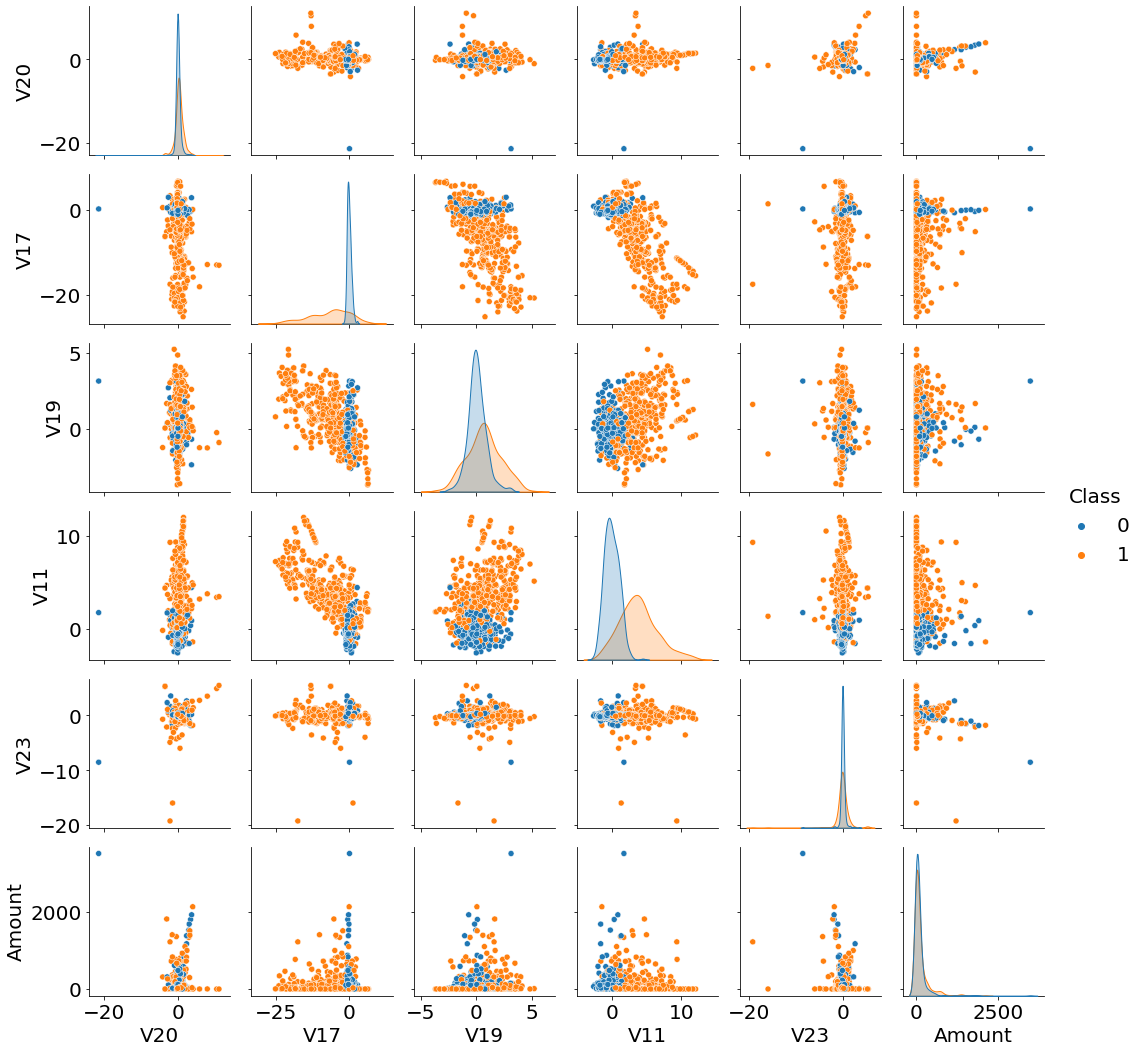

In [ ]:

# displaying class distribution for different features
sns_plot = sns.pairplot(underSample_df, hue = 'Class', vars = ['V20', 'V17', 'V19', 'V11', 'V23','Amount'] )


## Splitting and Scaling

Splitting the undersampled dataset into training and validation sets, In addition to scaling the "Time" and "Amounts" features

In [ ]:
#performing a new Split on the undesample_df into training and testing
X = underSample_df.drop('Class', axis=1)
y = underSample_df['Class']
y=pd.DataFrame(y)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [ ]:
# Scaling "Amount" and "Time" features in both the training and testing dataframes
ss = StandardScaler()

X_train_1["Amount"]= ss.fit_transform(X_train_1["Amount"].values.reshape(-1,1))
X_train_1["Time"]= ss.fit_transform(X_train_1["Time"].values.reshape(-1,1))

X_test_1["Amount"]= ss.fit_transform(X_test_1["Amount"].values.reshape(-1,1))
X_test_1["Time"]= ss.fit_transform(X_test_1["Time"].values.reshape(-1,1))

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr+ 'result/fraud/undersample/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

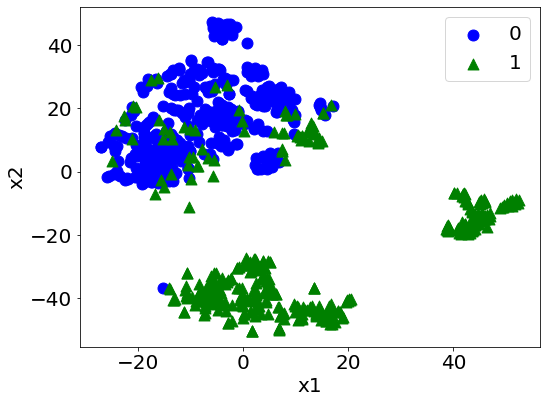

In [ ]:
#Plotting the train data
plot_scatter_tsne(X_train_1,
                  y_train_1, 
                  [0, 1],
                  ['0', '1'],
                  ['blue', 'green'],
                  ['o', '^'],
                  'best',
                  abspath_curr +'result/fraud/undersample/figure/',
                  'scatter_plot_classes.pdf',
                  random_seed)

## Modelling

Following undersampling and scaling, we can now try to fit a model to classify the fraud and non-fraud transactions. The models used in the section below are logistic regression, Random forest and MLP classifier. 


In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr+'result/fraud/undersample/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
#Creating a dictionary for the models

models = {'lr': LogisticRegression(random_state=random_seed),
         'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed)}

In [ ]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [ ]:
param_grids = {}

# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3]

# The parameter grid of C
C_grid = [0.1, 1, 10]

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]

# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

# The grids for alpha
alpha_grids = [10 ** i for i in range(-5, -2)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-4, -1)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

In [ ]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=2,
                      #cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_1, y_train_1)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

     #Write cv_results file
    cv_results.to_csv(path_or_buf=abspath_curr+'result/fraud/undersample/cv_results/GridSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.950209,"{'model__C': 0.1, 'model__tol': 1e-05}","(LogisticRegression(C=0.1, class_weight=None, ..."
1,0.945069,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
2,0.939977,"{'model__alpha': 1e-05, 'model__learning_rate_...","(MLPClassifier(activation='relu', alpha=1e-05,..."


After executing the different models we will pick the best model to analyze and plot the confusion matrix

In [ ]:
# Best model
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,confusion_matrix

# Get the prediction on the undersampled testing data using best_model
y_test_pred = best_estimator_gs.predict(X_test_1)

# Get the precision, recall, fscore, support
precision, recall, fscore, support = precision_recall_fscore_support(y_test_1, y_test_pred)

# Get the auc
auc = roc_auc_score(y_test_1, y_test_pred)

# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore, auc]], columns=['Precision', 'Recall', 'F1-score', 'AUC'])

,Precision,Recall,F1-score,AUC
0,"[0.8762886597938144, 0.98]","[0.9770114942528736, 0.8909090909090909]","[0.9239130434782609, 0.9333333333333333]",0.93396


Testing our model performance on the undersampled validation set resulted in a recall of 89% and high precision in classifying fraud and non-fraud transactions. 

Recall metric in the testing dataset:  0.8909090909090909


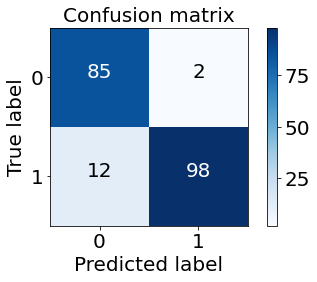

[[85  2]
 [12 98]]


In [ ]:
# Plotting confusion matrix obtained from the testing data predictions
cnf_matrix = confusion_matrix(y_test_1,y_test_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print(cnf_matrix)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,confusion_matrix

# Get the prediction on the testing data using best_model
y_test_pred_2 = best_estimator_gs.predict(original_Xtest)

# Get the precision, recall, fscore, support
precision, recall, fscore, support = precision_recall_fscore_support(original_ytest,y_test_pred_2)

# Get the auc
auc = roc_auc_score(original_ytest,y_test_pred_2)

# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore, auc]], columns=['Precision', 'Recall', 'F1-score', 'AUC'])

,Precision,Recall,F1-score,AUC
0,"[0.9998354421121919, 0.03922432789775231]","[0.9616622408244376, 0.9081632653061225]","[0.9803773923176907, 0.07520067596113224]",0.934913


As previously stated, testing our model against undersampled validation set resulted in promising results. However, in order to truly asses the performance of the model, we need to test it the highly imbalanced test set generated in the begining of this report. This resulted in a similar performance in terms of recall (90.8%). This means that the model was successful in classifying most fraudulent transactions. However, fraudulent transactions precision decreased (3%). this indicates that some Legit transactions were classified as fraudulent.  

Recall metric in the testing dataset:  0.9081632653061225


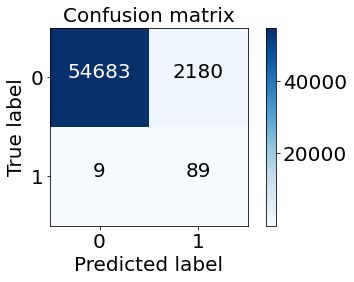

[[54683  2180]
 [    9    89]]


In [ ]:
cnf_matrix = confusion_matrix(original_ytest, y_test_pred_2)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print(cnf_matrix)

## Outliers Removal

In this section, We will try to improve the performance of the model. Intially, we investigated the correlation between the features with classes. It was noticed that features V10 , V12, V14 and V17 have a high negative correlation with the class. This means that the lower these features are the higher the tendency for this transaction to be fraudulent. In addition, It was also noticed that features V2, V4, V11 and V19 have a high positive correlation with the class. This means that the higher these features are the higher the tendency for this transaction to be fraudulent.

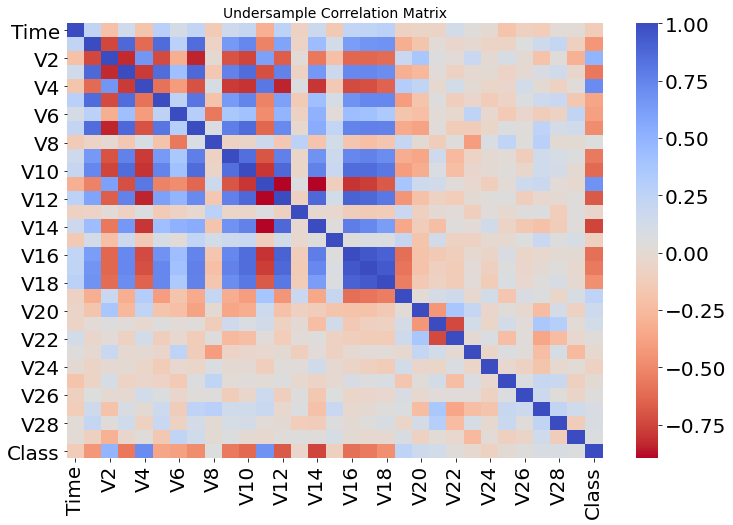

In [ ]:
#Plotting the correlation matrix from the undersampled_df
plt.figure(figsize=(12,8))

undersample_corr = underSample_df.corr()
sns.heatmap(undersample_corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.title('Undersample Correlation Matrix', fontsize=14)
plt.show()

By plotting the box plot for the features mentioned above, we can determine the presence of outliers that might affect the class determination.

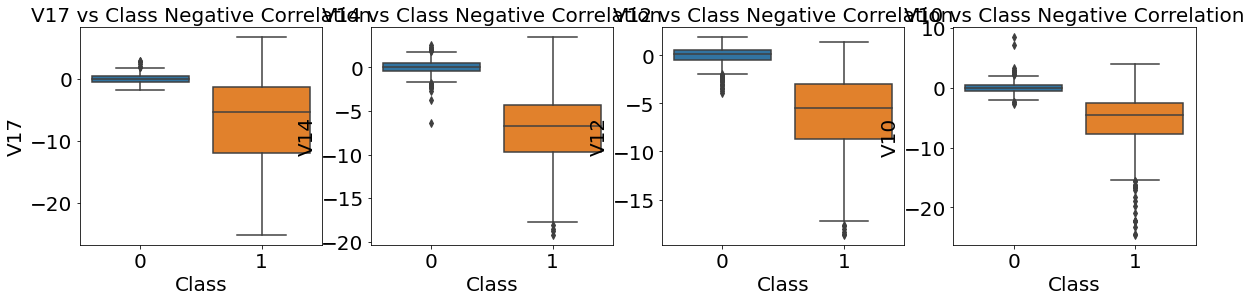

In [ ]:
# Plotting the boxplot for the most negatively correlated features to check for outliers

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=underSample_df, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=underSample_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=underSample_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=underSample_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

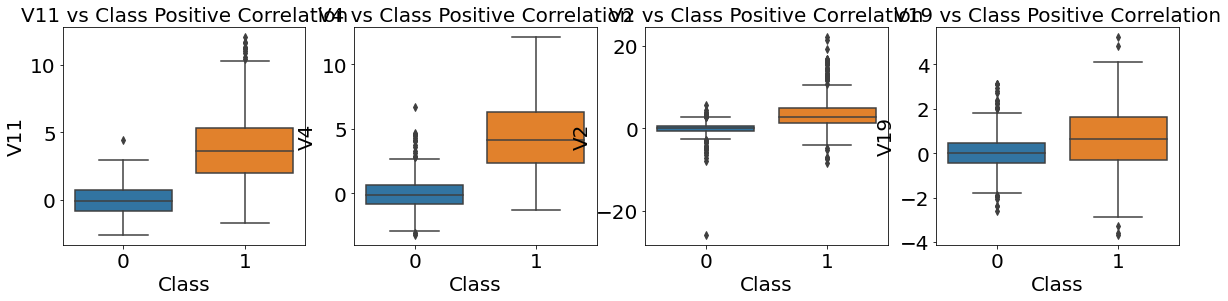

In [ ]:
# Plotting the boxplot for the most positively correlated features to check for outliers
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=underSample_df, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=underSample_df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=underSample_df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=underSample_df, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

There are different methods to determine the criteria to remove outliers. we determined the cutoff value by subtracting the 25th quartile from the 75th quartile and multiplying the outcome by 1.5. We removed values that lie with the upper and lower regions.

In [ ]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = underSample_df['V14'].loc[underSample_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))

underSample_df = underSample_df.drop(underSample_df[(underSample_df['V14'] > v14_upper) | (underSample_df['V14'] < v14_lower)].index)
print(20*"---")

# -----> V12 removing outliers from fraud transactions
v12_fraud = underSample_df['V12'].loc[underSample_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
underSample_df = underSample_df.drop(underSample_df[(underSample_df['V12'] > v12_upper) | (underSample_df['V12'] < v12_lower)].index)
print('Number of rows after outliers removal: {}'.format(len(underSample_df)))
print(20*"---")

# Removing outliers V10 Feature
v10_fraud = underSample_df['V10'].loc[underSample_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
underSample_df = underSample_df.drop(underSample_df[(underSample_df['V10'] > v10_upper) | (underSample_df['V10'] < v10_lower)].index)
print('Number of rows after outliers removal: {}'.format(len(underSample_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-19.2143254902614, -18.049997689859396, -18.4937733551053, -18.8220867423816]
------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.683714633344298, -18.553697009645802, -18.047596570821604, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of rows after outliers removal: 976
------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-15.563791338730098, -22.1870885620007, -24.403184969972802, -15.2399619587112, -16.3035376590131, -15.563791338730098, -18.9132433348732, -15.124162814494698, -22.1870885620007, -16.6496281595399, -22.1870885620007, -16.7460441053944, -16.6011969664137, -1

In [ ]:
# New X,y after removing outliers
X = underSample_df.drop('Class', axis=1)
y = underSample_df['Class']
y=pd.DataFrame(y)

In [ ]:
# Splitting again after removing outliers
X_train_2, X_test_2 ,y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [ ]:
# Scaling "Amount" and "Time" features in both the training and testing dataframes
ss = StandardScaler()

X_train_2["Amount"]= ss.fit_transform(X_train_2["Amount"].values.reshape(-1,1))
X_train_2["Time"]= ss.fit_transform(X_train_2["Time"].values.reshape(-1,1))

X_test_2["Amount"]= ss.fit_transform(X_test_2["Amount"].values.reshape(-1,1))
X_test_2["Time"]= ss.fit_transform(X_test_2["Time"].values.reshape(-1,1))

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr+'result/fraud/undersample/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

In the following section we will check to see if our model improved by removing the outliers.

In [ ]:
models = {'lr': LogisticRegression(random_state=random_seed),
         'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed)}

In [ ]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [ ]:
param_grids = {}

# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3]

# The parameter grid of C
C_grid = [0.1, 1, 10]

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]

# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

# The grids for alpha
alpha_grids = [10 ** i for i in range(-5, -2)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-4, -1)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr+'result/fraud/undersample/after_outlier/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=2,
                      #cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_2, y_train_2)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=abspath_curr+'result/fraud/undersample/after_outlier/cv_results/GridSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.944164,"{'model__C': 1, 'model__tol': 1e-05}","(LogisticRegression(C=1, class_weight=None, du..."
1,0.938653,"{'model__alpha': 1e-05, 'model__learning_rate_...","(MLPClassifier(activation='relu', alpha=1e-05,..."
2,0.937334,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."


In [ ]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,confusion_matrix

# Get the prediction on the undersampled testing data using best_model
y_test_pred_3 = best_estimator_gs.predict(X_test_2)

# Get the precision, recall, fscore, support
precision, recall, fscore, support = precision_recall_fscore_support(y_test_2, y_test_pred_3)

# Get the auc
auc = roc_auc_score(y_test_2, y_test_pred_3)

# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore, auc]], columns=['Precision', 'Recall', 'F1-score', 'AUC'])

,Precision,Recall,F1-score,AUC
0,"[0.9148936170212766, 0.9479166666666666]","[0.945054945054945, 0.9191919191919192]","[0.9297297297297297, 0.9333333333333333]",0.932123


Testing our model performance on the undersampled validation set resulted in a recall of 91% and high precision in classifying fraud and non-fraud transactions.

Recall metric in the testing dataset:  0.9191919191919192


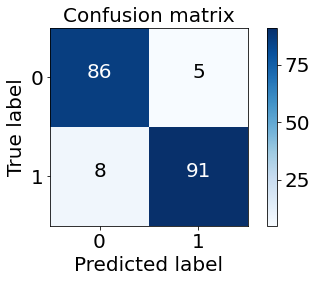

[[86  5]
 [ 8 91]]


In [ ]:
# Plotting the confusion matrix
cnf_matrix = confusion_matrix(y_test_2,y_test_pred_3)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print(cnf_matrix)

In [ ]:
# modeling the orginial testing dataframe
y_test_pred_4 = best_estimator_gs.predict(original_Xtest)

In [ ]:
precision, recall, fscore, support = precision_recall_fscore_support(original_ytest, y_test_pred_4)

# Get the auc
auc = roc_auc_score(original_ytest, y_test_pred_4)

# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore, auc]], columns=['Precision', 'Recall', 'F1-score', 'AUC'])

,Precision,Recall,F1-score,AUC
0,"[0.9999035158812859, 0.018096906012842966]","[0.9112603977982168, 0.9489795918367347]","[0.953526245572066, 0.035516517089936986]",0.93012


Same as the previous model, we need to test it the highly imbalanced test set generated in the begining of this report. This resulted in an improved performance in terms of recall (94.8%) compared to the initial model. This means that the model was better in classifying most fraudulent transactions. However, fraudulent transactions precision decreased (1.8%). this indicates that more Legit transactions were classified as fraudulent. A potential explanation to this result might be that removing outliers might have resulted in more features having similar distributions for both classes. However, Further investigation needed to find out the reason.

Recall metric in the testing dataset:  0.9489795918367347


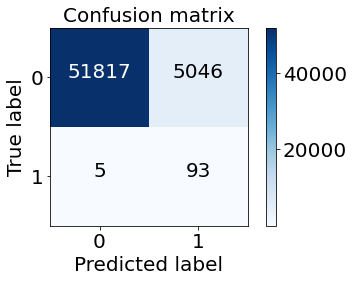

[[51817  5046]
 [    5    93]]


In [ ]:
cnf_matrix = confusion_matrix(original_ytest, y_test_pred_4)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print(cnf_matrix)

From the Random forest model, We were able to use the feature importance attribute to find out which features or PCA compnents contributed the most to the model. The following are the top five important features. An important observation is that V11, V17 and V20 were identified as the top three features, were some of the features subjected to the outliers elimination process. This might be an explanation to the improvement in the recall performance.  

In [ ]:
target="Class"
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_params_estimator_gs[2]

# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((np.setdiff1d(underSample_df.columns, [target]).reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_rfc
df_fi_rfc.head()

,Features,Importance
0,V20,0.193456
1,V11,0.115314
2,V17,0.107365
3,V19,0.0937729
4,V23,0.0840129


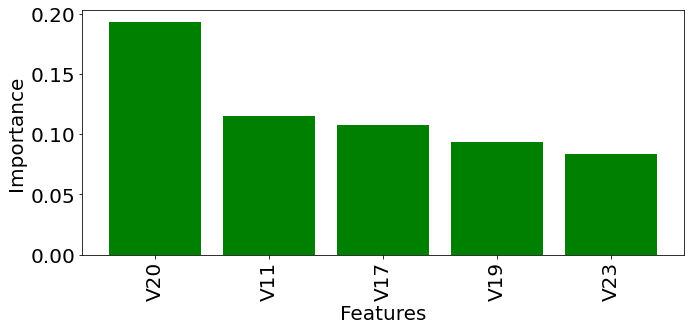

In [ ]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# Implement me
# The bar plot of the top 5 feature importance
plt.bar(df_fi_rfc['Features'][:5], df_fi_rfc['Importance'][:5], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr+'result/fraud/undersample/figure/feature_importance_rfc.pdf')
plt.show()

# OverSampling

Previously, we tried undersampling to handle the highly imbalance data. In the next section we will use SMOTE and ADASYN oversample techniques to balance the data and then try fit model to classify fraudulent and legit transactions. 

In [ ]:
# Load data
df = pd.read_csv(abspath_curr+'data/credit_card_fraud_detection/creditcard.csv')


from sklearn.model_selection import StratifiedShuffleSplit


print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X_2 = df.drop('Class', axis=1)
y_2 = df['Class']
#using StratifiedKfold to generate (Train dataframe and  Test dataframe ) having the same class distribution that is similar to the orginial data

sss_2 = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss_2.split(X_2, y_2):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain_2, original_Xtest_2 = X_2.iloc[train_index], X_2.iloc[test_index]
    original_ytrain_2, original_ytest_2 = y_2.iloc[train_index], y_2.iloc[test_index]
    


# Verify the Distribution of the labels


# Turn into an array
original_Xtrain_array_2 = original_Xtrain_2.values
original_Xtest_array_2 = original_Xtest_2.values
original_ytrain_array_2 = original_ytrain_2.values
original_ytest_array_2 = original_ytest_2.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain_array_2, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest_array_2, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain_array_2))
print(test_counts_label/ len(original_ytest_array_2))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[1. 0.]
[1. 0.]


In [ ]:
np.unique(original_ytrain_array_2, return_counts=True)

(array([0, 1]), array([227452,    394]))

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

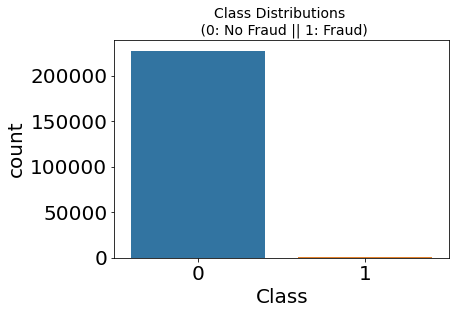

In [ ]:
#plotting the class Distribution

combined_df = original_Xtrain_2.copy(deep=False)
combined_df["Class"] = original_ytrain_2
sns.countplot('Class', data=combined_df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
#combined_df.head()

## Oversampling using SMOTE

Validate the shape of the current data before resampling

In [ ]:
original_Xtrain_2.shape

(227846, 30)

In [ ]:
original_Xtrain_2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [ ]:
original_ytrain.shape

(227846, 1)

In [ ]:
original_ytrain.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [ ]:
from imblearn.over_sampling import SMOTE

# resmapling
X_resampled, y_resampled = SMOTE().fit_sample(original_Xtrain_2, original_ytrain_2)

# convert the oversampled data into a dataframe
# Defining the columns of the dataframe
column_values = ['Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] 


X_resampled_df_SMOTE = pd.DataFrame(data=X_resampled, columns=column_values)
y_resampled_df_SMOTE = pd.DataFrame(data=y_resampled, columns=['Class'])


After SMOTE oversampling, a new dataset with equal class distribution was generated. 

Text(0.5, 1.0, 'Class Distributions after SMOTE \n (0: No Fraud || 1: Fraud)')

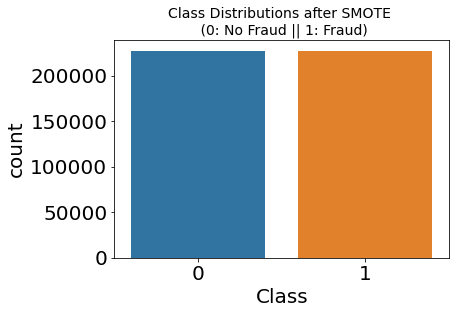

In [ ]:
#combined_oversampled_df_SMOTE = X_resampled_df_SMOTE
#combined_oversampled_df_SMOTE["Class"] = y_resampled_df_SMOTE
sns.countplot('Class', data=y_resampled_df_SMOTE)
plt.title('Class Distributions after SMOTE \n (0: No Fraud || 1: Fraud)', fontsize=14)

A comparison between the original transaction amount and other features distributions for both classes shows that the newly added synthetic minority class did not change the original distributions. This is imperative for the authenticity of the resulting model and directly affects its performance. It is clear from the transaction amount pie chart below, that the transaction amount portions is almost similar to the original distribution. In addition, this is also observed in the feature by feature classes distribution plot below.   

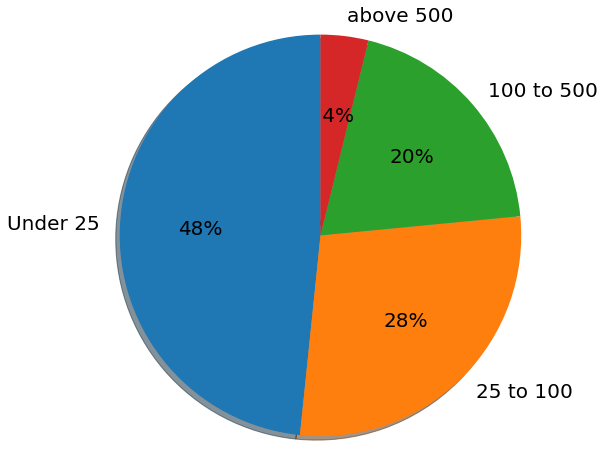

In [ ]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,8))
amount = X_resampled_df_SMOTE['Amount']
amount.shape
amount_under_25 = amount[amount[:]<25]
amount_btw_25_100 = amount[(amount >= 25) & (amount < 100)]
amount_btw_100_500 = amount[(amount >= 100) & (amount < 500)]
amount_above_500 = amount[(amount >= 500)]

data = [len(amount_under_25), len(amount_btw_25_100),len(amount_btw_100_500),len(amount_above_500)]
explode = (0, 0, 0, 0) 
labels = ["Under 25", "25 to 100","100 to 500","above 500"]


ax1.pie(data, explode=explode, labels=labels, autopct='%2.0f%%',
        shadow=True, startangle=90)


ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

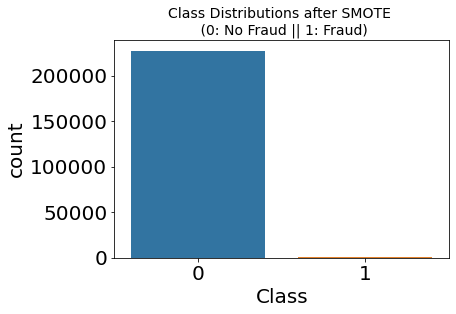

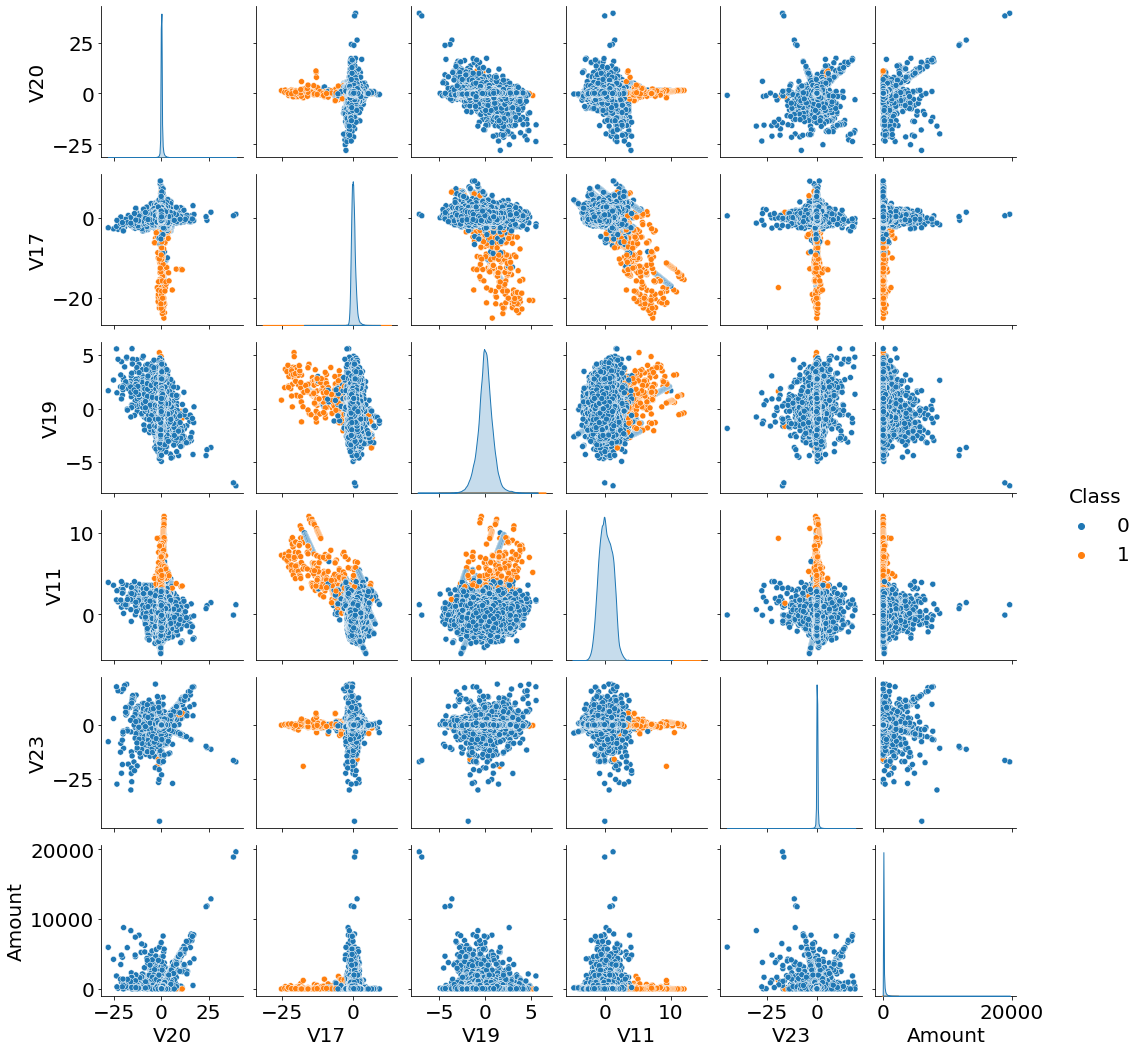

In [ ]:
combined_train_df = original_Xtrain_2.copy()
combined_train_df['Class'] = original_ytrain_2.copy()
sns.countplot('Class', data=combined_train_df)
plt.title('Class Distributions before SMOTE \n (0: No Fraud || 1: Fraud)', fontsize=14)

sns_plot = sns.pairplot(combined_train_df, hue = 'Class', vars = ['V20', 'V17', 'V19', 'V11', 'V23','Amount'] )
sns_plot.savefig("Before_Oversample.png")


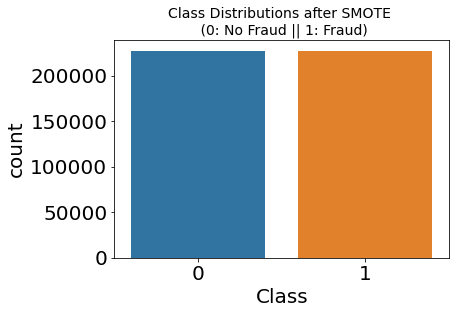

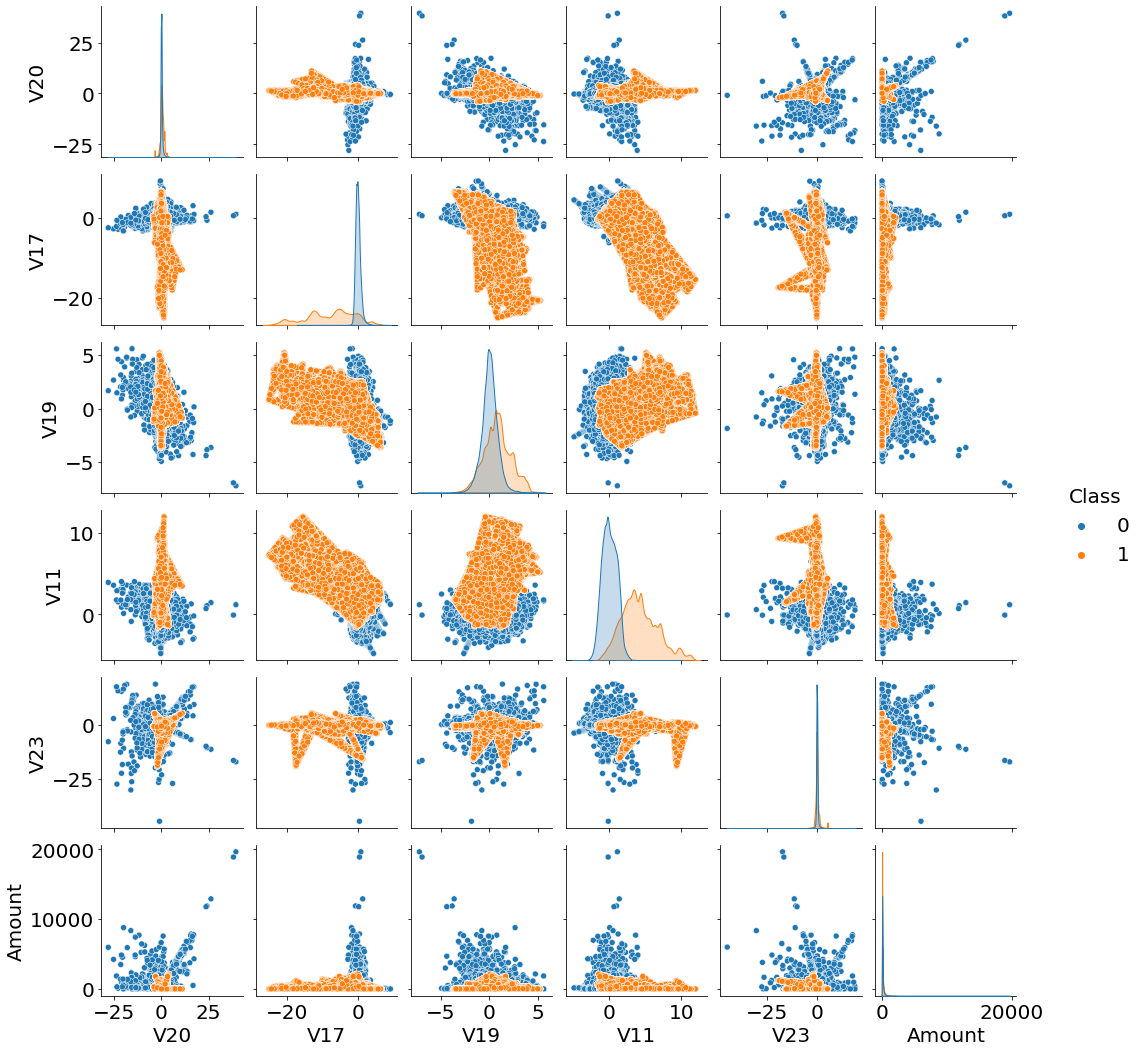

In [ ]:
combined_oversampled_df_SMOTE = X_resampled_df_SMOTE.copy()
combined_oversampled_df_SMOTE["Class"] = y_resampled_df_SMOTE
sns.countplot('Class', data=combined_oversampled_df_SMOTE)
plt.title('Class Distributions after SMOTE \n (0: No Fraud || 1: Fraud)', fontsize=14)

sns_plot = sns.pairplot(combined_oversampled_df_SMOTE, hue = 'Class', vars = ['V20', 'V17', 'V19', 'V11', 'V23','Amount'] )
sns_plot.savefig("After_SMOTE_Oversample.png")

In [ ]:
X_resampled_df_SMOTE.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


### Spliting and Scaling 

Now, we can split the oversampled dataset into training and validation set, In addition to scaling the "Time" and "Amount" features.

In [ ]:
X_train_3, X_test_3 ,y_train_3, y_test_3 = train_test_split(X_resampled_df_SMOTE, y_resampled_df_SMOTE, test_size=0.2, random_state=random_seed)


In [ ]:
X_train_3.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
392728,-0.398022,-4.845502,2.216691,-4.823322,4.204030,-2.470015,-1.079343,-5.739165,0.031128,-2.695110,-6.251910,4.362378,-6.299683,-0.702487,-7.876684,0.103449,-6.193505,-9.142318,-3.623385,1.837380,0.153860,0.390524,0.434645,-0.315955,-0.089699,-0.266044,-0.199003,0.937904,0.254306,-0.123159
205206,1.686452,1.785169,-0.977434,-2.307540,-0.212162,-0.255255,-1.759956,0.798235,-0.671291,-1.532365,1.106958,1.259023,0.854170,0.217077,0.896447,-1.144798,-2.250880,0.134913,0.904188,-0.657360,-0.218731,0.110524,0.489787,-0.214691,0.642987,0.336377,0.942522,-0.160481,-0.060656,0.503801
416033,-1.196508,-16.820240,10.678443,-19.955796,6.092837,-13.157539,-4.120336,-14.239741,11.276111,-3.666224,-9.324335,6.603467,-9.726271,0.431096,-9.264783,-0.190868,-7.510396,-13.963910,-4.937140,1.349856,1.530573,1.679300,-1.231992,-0.685195,0.088612,1.078164,-0.246641,1.685414,0.511731,0.009738
355361,-0.042600,1.074680,1.134368,-1.504238,2.063398,0.512275,-1.172288,0.085991,0.067623,-0.041911,-1.997463,2.294486,-0.682704,-1.751601,-4.554771,-0.360831,1.215970,3.184808,2.133489,-0.413412,-0.058296,-0.320072,-0.865999,-0.168191,-0.094123,0.665798,-0.350856,0.100959,0.128076,-0.392554
8296,-1.566167,-2.125490,5.973556,-11.034727,9.007147,-1.689451,-2.854415,-7.810441,2.030870,-5.902828,-12.840934,12.018913,-17.769143,-0.431036,-19.214325,-0.962465,-10.266609,-15.503392,-5.494928,-0.410481,1.493775,1.646518,-0.278485,-0.664841,-1.164555,1.701796,0.690806,2.119749,1.108933,-0.434834


In [ ]:
# Scaling "Amount" and "Time" features in both the training and testing dataframes
ss = StandardScaler()

X_train_3["Amount"]= ss.fit_transform(X_train_3["Amount"].values.reshape(-1,1))
X_train_3["Time"]= ss.fit_transform(X_train_3["Time"].values.reshape(-1,1))

X_test_3["Amount"]= ss.fit_transform(X_test_3["Amount"].values.reshape(-1,1))
X_test_3["Time"]= ss.fit_transform(X_test_3["Time"].values.reshape(-1,1))

### Modelling

We are now ready to fit a model that classifies the fraudulent and legit transaction. 

In [ ]:
models = {'lr': LogisticRegression(random_state=random_seed),

}

In [ ]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [ ]:
param_grids = {}

# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3]

# The parameter grid of C
C_grid = [0.1, 1, 10]

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]


In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr+'result/fraud/oversample/SMOTE/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=2,
                      #cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_3, y_train_3)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=abspath_curr+'result/fraud/oversample/SMOTE/cv_results/GridSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.981532,"{'model__C': 10, 'model__tol': 1e-05}","(LogisticRegression(C=10, class_weight=None, d..."


In [ ]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,confusion_matrix

# Get the prediction on the undersampled testing data using best_model
y_test_pred_4 = best_estimator_gs.predict(X_test_3)

# Get the precision, recall, fscore, support
precision, recall, fscore, support = precision_recall_fscore_support(y_test_3, y_test_pred_4)

# Get the auc
auc = roc_auc_score(y_test_3, y_test_pred_4)

# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore, auc]], columns=['Precision', 'Recall', 'F1-score', 'AUC'])

,Precision,Recall,F1-score,AUC
0,"[0.9743061131485862, 0.9900668151447661]","[0.9901638621176366, 0.9740567071300232]","[0.9821709835491774, 0.9819965097528109]",0.98211


Testing our model performance on the oversampled validation set resulted in a recall of 97% and high precision in classifying fraud and non-fraud transactions.

Recall metric in the testing dataset:  0.9740567071300232


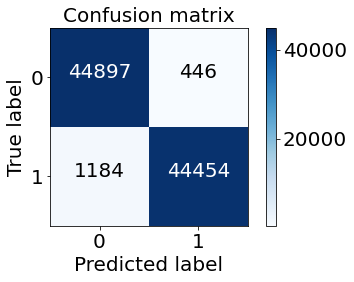

[[44897   446]
 [ 1184 44454]]


In [ ]:
# Plotting the confusion matrix
cnf_matrix = confusion_matrix(y_test_3,y_test_pred_4)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print(cnf_matrix)

In [ ]:
# modeling the orginial testing dataframe
y_test_pred_5 = best_estimator_gs.predict(original_Xtest)

In [ ]:
precision, recall, fscore, support = precision_recall_fscore_support(original_ytest, y_test_pred_5)

# Get the auc
auc = roc_auc_score(original_ytest, y_test_pred_5)

# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore, auc]], columns=['Precision', 'Recall', 'F1-score', 'AUC'])

,Precision,Recall,F1-score,AUC
0,"[0.9998020977637048, 0.06313497822931785]","[0.9772963086717198, 0.8877551020408163]","[0.9884211087988901, 0.11788617886178862]",0.932526


In order to truly asses the performance of the model, we need to test it the highly imbalanced test set generated in the begining of this report. This resulted in a lower recall (88.8%). This means that the model was successful in classifying most fraudulent transactions but at a lower percentage. However, fraudulent transactions precision decreased (6%), meaning more legit transactions were classified as fraudulent.


Recall metric in the testing dataset:  0.8877551020408163


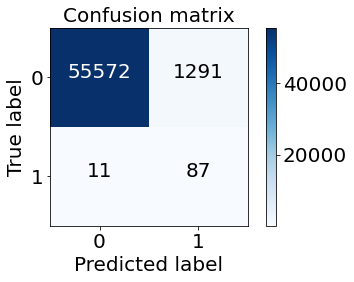

[[55572  1291]
 [   11    87]]


In [ ]:
cnf_matrix = confusion_matrix(original_ytest, y_test_pred_5)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print(cnf_matrix)

## Oversampling using ADASYN

In this section we will use a different oversampling techinque and asses results. 

In [ ]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(original_Xtrain_2, original_ytrain_2)

# convert the data to dataframe
column_values = ['Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] 

X_resampled_df_ADASYN = pd.DataFrame(data=X_resampled, columns=column_values)
y_resampled_df_ADASYN = pd.DataFrame(data=y_resampled, columns=['Class'])


In [ ]:
X_resampled_df_ADASYN.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Oversampling using ADASYN resulted in an equally class distribution dataset.

Text(0.5, 1.0, 'Class Distributions after ADASYN \n (0: No Fraud || 1: Fraud)')

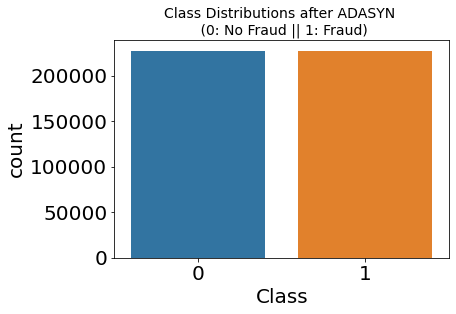

In [ ]:
combined_oversampled_df_ADASYN = X_resampled_df_ADASYN.copy()
combined_oversampled_df_ADASYN["Class"] = y_resampled_df_ADASYN
sns.countplot('Class', data=y_resampled_df_ADASYN)
plt.title('Class Distributions after ADASYN \n (0: No Fraud || 1: Fraud)', fontsize=14)

Similar to SMOTE oversampling, A comparison between the original transaction amount and other features distributions for both classes also showed that the newly added synthetic minority class resulted in having similar distribution for both classes in all features. It is clear from the transaction amount pie chart below, that the transaction amount portions is almost similar to the original distribution. In addition, this is also observed in the feature by feature classes distribution plot below.  

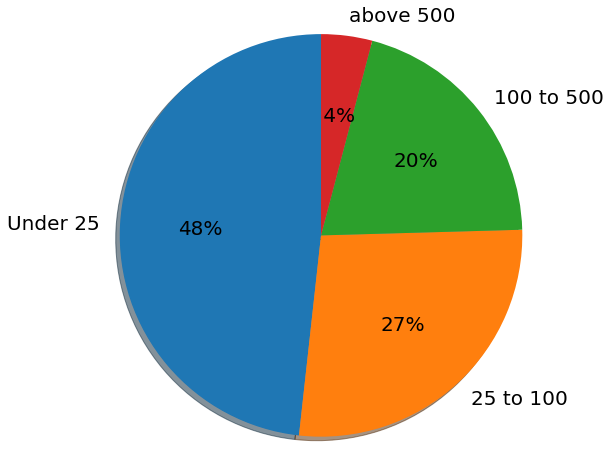

In [ ]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,8))
amount = X_resampled_df_ADASYN['Amount']
amount.shape
amount_under_25 = amount[amount[:]<25]
amount_btw_25_100 = amount[(amount >= 25) & (amount < 100)]
amount_btw_100_500 = amount[(amount >= 100) & (amount < 500)]
amount_above_500 = amount[(amount >= 500)]

data = [len(amount_under_25), len(amount_btw_25_100),len(amount_btw_100_500),len(amount_above_500)]
explode = (0, 0, 0, 0) 
labels = ["Under 25", "25 to 100","100 to 500","above 500"]


ax1.pie(data, explode=explode, labels=labels, autopct='%2.0f%%',
        shadow=True, startangle=90)


ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

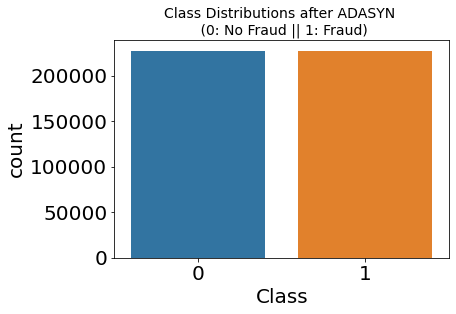

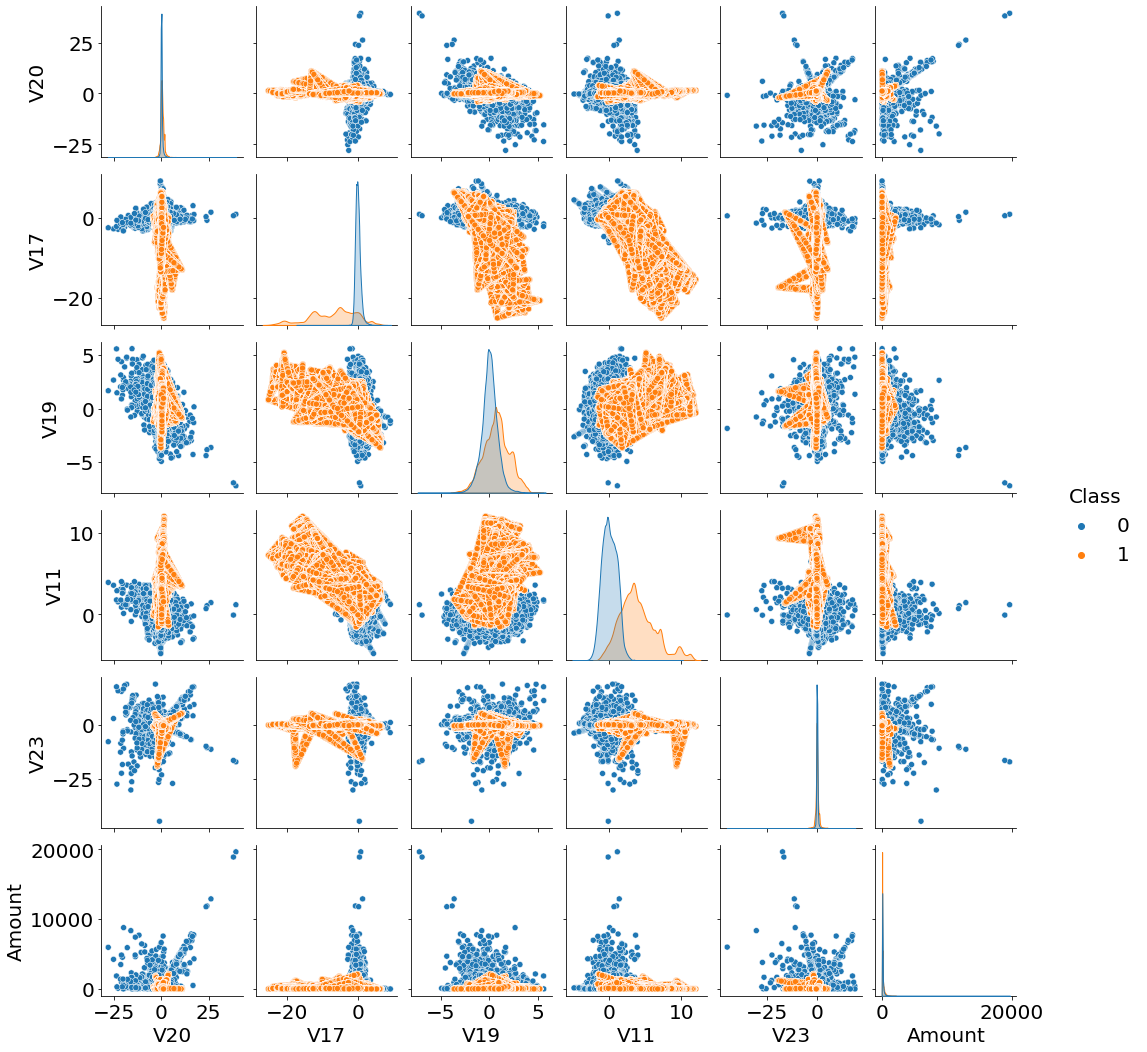

In [ ]:
combined_oversampled_df_ADASYN = combined_oversampled_df_ADASYN.copy()
combined_oversampled_df_ADASYN["Class"] = y_resampled_df_ADASYN
sns.countplot('Class', data=combined_oversampled_df_ADASYN)
plt.title('Class Distributions after ADASYN \n (0: No Fraud || 1: Fraud)', fontsize=14)

sns_plot = sns.pairplot(combined_oversampled_df_ADASYN, hue = 'Class', vars = ['V20', 'V17', 'V19', 'V11', 'V23','Amount'] )
sns_plot.savefig("After_ADASYN_Oversample.png")

In [ ]:
X_resampled_df_ADASYN.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


### Splitting and Scaling

Now, we can split the oversampled dataset into training and validation set, In addition to scaling the "Time" and "Amount" features.

In [ ]:
X_train_4, X_test_4 ,y_train_4, y_test_4 = train_test_split(X_resampled_df_ADASYN, y_resampled_df_ADASYN, test_size=0.2, random_state=random_seed)



In [ ]:
# Scaling "Amount" and "Time" features in both the training and testing dataframes
ss = StandardScaler()

X_train_4["Amount"]= ss.fit_transform(X_train_4["Amount"].values.reshape(-1,1))
X_train_4["Time"]= ss.fit_transform(X_train_4["Time"].values.reshape(-1,1))

X_test_4["Amount"]= ss.fit_transform(X_test_4["Amount"].values.reshape(-1,1))
X_test_4["Time"]= ss.fit_transform(X_test_4["Time"].values.reshape(-1,1))

In [ ]:
X_train_4.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
154726,0.822238,-0.869197,0.842258,1.204031,-0.611522,-0.260860,0.160952,-0.372156,0.741253,1.451718,-0.986852,1.079650,-2.755852,-0.113630,1.986545,-1.075365,0.700879,0.134630,1.305737,-0.353707,-0.176510,0.189549,0.731991,-0.195336,0.719896,-0.196307,0.565680,0.175834,0.120847,-0.419145
280828,-0.954189,0.461376,1.642627,-2.232362,3.362873,0.035686,-0.074025,-1.736052,0.573336,-2.106025,-2.407341,2.865992,-2.598185,0.646562,-5.016085,0.234576,-1.095997,-3.784502,-0.599636,-0.623978,0.346301,0.417449,0.110753,-0.307265,-1.007215,0.786857,0.242562,0.471562,0.257709,-0.363382
4541,-1.743758,0.729396,-0.503222,1.695198,3.278349,-1.219936,0.605991,-0.713572,0.221000,2.033666,-0.072029,-0.580657,-2.756508,0.404009,0.890991,-1.926392,0.275648,0.738685,0.122762,-0.817241,0.084864,-0.162545,-0.378232,-0.140824,0.327358,0.248840,-0.020568,-0.007328,0.059681,0.395528
280007,-0.945059,-1.312146,1.895110,-1.654583,1.681512,-1.209705,-0.795998,-1.539278,-1.480469,-0.414771,-2.320940,3.015165,-4.512216,-0.714188,-6.553418,0.248145,-3.194220,-6.376847,-2.317530,-0.088947,0.296216,1.155332,-0.622123,0.061851,0.074412,0.080960,0.130934,-0.175914,-0.502230,-0.067232
439279,1.493716,-5.187323,2.675540,-4.276514,0.478874,-0.438019,0.635123,-5.008624,-7.500687,0.152578,-2.430355,2.003382,-1.990633,-0.676925,-4.492555,-1.746715,-1.825058,-3.685713,-0.830290,0.249159,-2.534308,8.334277,-2.566276,0.462138,0.089366,0.295703,0.515330,0.193249,0.355138,-0.411139


### Modelling

We are now ready to fit a model that classifies the fraudulent and legit transaction. 

In [ ]:
models = {'lr': LogisticRegression(random_state=random_seed),
          #'lr_mbgd': LogisticRegression_MBGD()}
         #'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          #'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed)}
}

In [ ]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [ ]:
param_grids = {}

# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3]

# The parameter grid of C
C_grid = [0.1, 1, 10]

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]
# The parameter grid of eta

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr+'result/fraud/oversample/ADASYN/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=2,
                      #cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_4, y_train_4)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=abspath_curr+'result/fraud/oversample/ADASYN/cv_results/GridSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.980749,"{'model__C': 10, 'model__tol': 1e-05}","(LogisticRegression(C=10, class_weight=None, d..."


In [ ]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,confusion_matrix

# Get the prediction on the undersampled testing data using best_model
y_test_pred_5 = best_estimator_gs.predict(X_test_4)

# Get the precision, recall, fscore, support
precision, recall, fscore, support = precision_recall_fscore_support(y_test_4, y_test_pred_5)

# Get the auc
auc = roc_auc_score(y_test_4, y_test_pred_5)

# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore, auc]], columns=['Precision', 'Recall', 'F1-score', 'AUC'])

,Precision,Recall,F1-score,AUC
0,"[0.9707473754553881, 0.9905112272594719]","[0.9906940930590694, 0.9701843429349856]","[0.9806193110056182, 0.9802424188607202]",0.980439


Testing our model performance on the oversampled validation set resulted in a recall of 97% and high precision in classifying fraud and non-fraud transactions.

Recall metric in the testing dataset:  0.9701843429349856


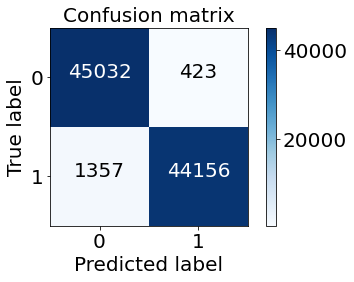

[[45032   423]
 [ 1357 44156]]


In [ ]:
# Plotting the confusion matrix
cnf_matrix = confusion_matrix(y_test_4,y_test_pred_5)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print(cnf_matrix)

In [ ]:
# modeling the orginial testing dataframe
y_test_pred_6 = best_estimator_gs.predict(original_Xtest)

In [ ]:
precision, recall, fscore, support = precision_recall_fscore_support(original_ytest, y_test_pred_6)

# Get the auc
auc = roc_auc_score(original_ytest, y_test_pred_6)

# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore, auc]], columns=['Precision', 'Recall', 'F1-score', 'AUC'])

,Precision,Recall,F1-score,AUC
0,"[0.9998013866820743, 0.055168040583386174]","[0.973796669187345, 0.8877551020408163]","[0.9866277049720704, 0.10388059701492537]",0.930776


Testing our model on the testing dataset generated in the begining of the report resulted in a lower recall (88.8%). This means that the model was successful in classifying most fraudulent transactions but at a lower percentage. However, fraudulent transactions precision decreased (5.5%), meaning more legit transactions were classified as fraudulent.

It is observed that models dervied from SMOTE and ADASYN oversampling techniques resulted in similar performances. There was a slight difference in the precision of detecting the minority class where using SMOTE resulted in a 0.5% higher precision.

Recall metric in the testing dataset:  0.8877551020408163


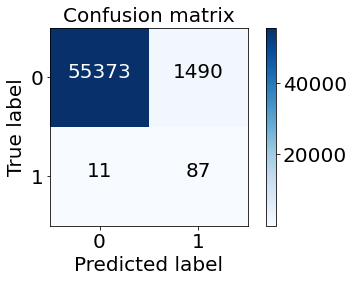

[[55373  1490]
 [   11    87]]


In [ ]:


cnf_matrix = confusion_matrix(original_ytest, y_test_pred_6)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
print(cnf_matrix)

# Undersampling and Oversampling Comparison

There are various ways to compare between the performance of the derived model from both techniques used to handle the highly imbalance data.we will be focusing on classifying the fraudulent transactions when comparing between both.On one hand, Models derived from undersampling datasets where characterized by having a higher recall but a lower precision when compared to models derived from oversampling techniques. Which means that these models were able to identify fraudulent transactions at a higher rate ,In addition to wrongfuly classifying legit transactions to be fraud at a higher rate.  On the the other hand, Models derived from oversampling techniques had a lower recall but a much improved precision. 

There is a recall/Precision balance that was noticed through different derived models. Where an increase in recall resulted in a decrease in precision and vice vera. In the following section, we will attempt to train a deep network model to see if an improved model can be obtained.

# Neural Network Model

## DNN using SMOTE oversampled data

### Building the model

In [ ]:
# A sequential DNN
model = keras.models.Sequential()

# Add the input layer for the number of input
model.add(keras.layers.Dense(units=200, input_dim=29, kernel_initializer='uniform', activation='relu'))
model.add(keras.layers.Dropout(0.5))

# Hidden layer 1
model.add(keras.layers.Dense(units=200,  kernel_initializer='uniform', activation='relu'))
model.add(keras.layers.Dropout(0.5))

# Hidden layer 1
model.add(keras.layers.Dense(units=200,  kernel_initializer='uniform', activation='relu'))
model.add(keras.layers.Dropout(0.5))

# Output layer using Sigmoid 
model.add(keras.layers.Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               6000      
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

### Compiling the model

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.SGD(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Training

#### Setting callbacks

In [ ]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/model.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=5)

abspath_curr

'/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/homework/Project/'

#### Training, evaluating and saving the best model using SMOTE oversampled data

In [ ]:
X_resampled_df_SMOTE =  X_resampled_df_SMOTE.drop(['Time'], axis=1)

In [ ]:
#X_resampled_df_SMOTE,y_resampled_df_SMOTE
# Train, evaluate and save the best model

history = model.fit(x=X_resampled_df_SMOTE, y=y_resampled_df_SMOTE,
                    epochs=20,
                    validation_split=0.4,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/20
8530/8530 [==============================] - 23s 3ms/step - loss: 0.2234 - accuracy: 0.9321 - val_loss: 0.5609 - val_accuracy: 0.7568
Epoch 2/20
8530/8530 [==============================] - 23s 3ms/step - loss: 0.1384 - accuracy: 0.9563 - val_loss: 0.3727 - val_accuracy: 0.8200
Epoch 3/20
8530/8530 [==============================] - 23s 3ms/step - loss: 0.1208 - accuracy: 0.9633 - val_loss: 0.3822 - val_accuracy: 0.8448
Epoch 4/20
8530/8530 [==============================] - 23s 3ms/step - loss: 0.0985 - accuracy: 0.9705 - val_loss: 0.2749 - val_accuracy: 0.9071
Epoch 5/20
8530/8530 [==============================] - 23s 3ms/step - loss: 0.0915 - accuracy: 0.9731 - val_loss: 0.2149 - val_accuracy: 0.9241
Epoch 6/20
8530/8530 [==============================] - 23s 3ms/step - loss: 0.0818 - accuracy: 0.9763 - val_loss: 0.2645 - val_accuracy: 0.9113
Epoch 7/20
8530/8530 [==============================] - 23s 3ms/step - loss: 0.0833 - accuracy: 0.9766 - val_loss: 0.1700 - val_ac

In [ ]:
model.save_weights(filepath=abspath_curr + 'result/ANN_model/model_SMOTE.h5')

#### Plotting the learning curve

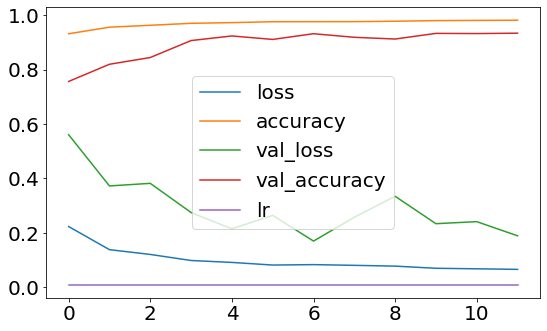

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

import pandas as pd

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_DNN_curve_SMOTE.pdf')
plt.show()

## DNN using ADASYN oversampled data

### Building the model

In [ ]:
# A sequential DNN
model2 = keras.models.Sequential()

# Add the input layer for the number of input
model2.add(keras.layers.Dense(units=200, input_dim=29, kernel_initializer='uniform', activation='relu'))
model2.add(keras.layers.Dropout(0.5))

# Hidden layer 1
model2.add(keras.layers.Dense(units=200,  kernel_initializer='uniform', activation='relu'))
model2.add(keras.layers.Dropout(0.5))

# Hidden layer 1
model2.add(keras.layers.Dense(units=200,  kernel_initializer='uniform', activation='relu'))
model2.add(keras.layers.Dropout(0.5))

# Output layer using Sigmoid 
model2.add(keras.layers.Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))


model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 200)               6000      
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

### Compiling the model

In [ ]:
# Compile the model
model2.compile(optimizer=keras.optimizers.SGD(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Training

#### Setting callback

In [ ]:
# ModelCheckpoint callback
model2_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/model.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb2 = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb2 = keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=5)


#### Training, evaluating and saving the best model using ADASYN oversampled data

In [ ]:
X_resampled_df_ADASYN.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [ ]:
# drop the time feature
X_resampled_df_ADASYN =  X_resampled_df_ADASYN.drop(['Time'], axis=1)

In [ ]:
history = model2.fit(x=X_resampled_df_ADASYN, y=y_resampled_df_ADASYN,
                    epochs=20,
                    validation_split=0.3,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/20
9950/9950 [==============================] - 26s 3ms/step - loss: 0.1901 - accuracy: 0.9447 - val_loss: 0.2988 - val_accuracy: 0.8533
Epoch 2/20
9950/9950 [==============================] - 24s 2ms/step - loss: 0.1053 - accuracy: 0.9671 - val_loss: 0.4405 - val_accuracy: 0.8013
Epoch 3/20
9950/9950 [==============================] - 25s 2ms/step - loss: 0.0848 - accuracy: 0.9737 - val_loss: 0.4417 - val_accuracy: 0.7998
Epoch 4/20
9950/9950 [==============================] - 25s 3ms/step - loss: 0.0783 - accuracy: 0.9755 - val_loss: 0.3727 - val_accuracy: 0.7934
Epoch 5/20
9950/9950 [==============================] - 24s 2ms/step - loss: 0.0683 - accuracy: 0.9792 - val_loss: 0.3843 - val_accuracy: 0.9007
Epoch 6/20
9950/9950 [==============================] - 24s 2ms/step - loss: 0.0675 - accuracy: 0.9798 - val_loss: 0.2825 - val_accuracy: 0.8831
Epoch 7/20
9950/9950 [==============================] - 24s 2ms/step - loss: 0.0660 - accuracy: 0.9802 - val_loss: 0.4320 - val_ac

In [ ]:
model2.save_weights(filepath=abspath_curr + 'result/ANN_model/model2_ADASYN.h5')

#### Plotting the learning curve

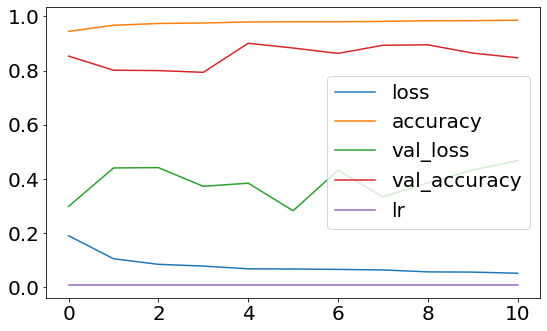

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

import pandas as pd

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_DNN_curve2.pdf')
plt.show()

## Testing

### SMOTE

In [ ]:
# Load the saved model 1
model.load_weights(filepath=abspath_curr + 'result/ANN_model/model_SMOTE.h5')

# Drop time from original test data
original_Xtest_noTime =  original_Xtest.drop(['Time'], axis=1)
loss, accuracy = model.evaluate(x=original_Xtest_noTime, y=original_ytest)


1781/1781 [==============================] - 2s 1ms/step - loss: 0.0177 - accuracy: 0.9950


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Recall metric in the testing dataset:  0.8469387755102041


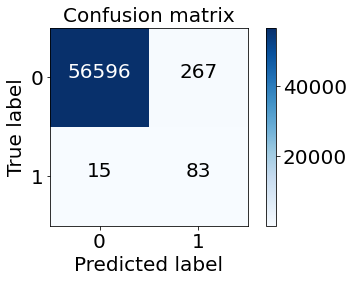

In [ ]:
from sklearn.metrics import roc_auc_score,confusion_matrix

y_pred=model.predict_classes(original_Xtest_noTime)
y_expected=original_ytest.values

cnf_matrix = confusion_matrix(y_expected, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
#print(cnf_matrix)

### ADASYN

In [ ]:
# Load the saved model 2
model2.load_weights(filepath=abspath_curr + 'result/ANN_model/model2.h5')
loss, accuracy = model.evaluate(x=original_Xtest_noTime, y=original_ytest)


1781/1781 [==============================] - 2s 1ms/step - loss: 0.0177 - accuracy: 0.9950


Recall metric in the testing dataset:  0.8469387755102041


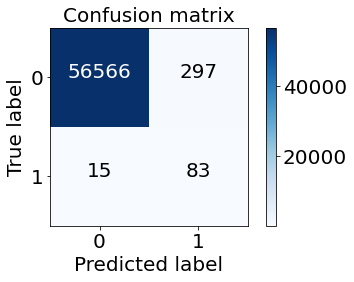

In [ ]:
from sklearn.metrics import roc_auc_score,confusion_matrix

y_pred=model2.predict_classes(original_Xtest_noTime)
y_expected=original_ytest.values

cnf_matrix = confusion_matrix(y_expected, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
#print(cnf_matrix)

## DNN result analysis

The performance of the model trained using SOMTE and ADASYN oversampled data resulted in similar performance metric results with a slight higher precision in detecting the fraudulent transaction for SMOTE. 

The resulting model performance in the testing set was slighlty less successful in detetcting fraudulent transactions with a recall of 84.6% compared to the shallow models trained using oversampled data. However, a significant improvement in the minority class precision was observed. The presicion obtained from testing was 23.7%. Where the precision obtained from the best shallow model was 6.3%. This indicates that the DNN model was more successful the overall classification of the fraudulent transactions. 

#Conclusion

This report is a study of close to 250,000 transactions made by credit cards in September 2013 by european cardholders over the period of two days. The dataset features are an outcome of PCA components, in addition to the time and amount of transaction. the amount of fraudulent transactions represents 0.17% of all transactions. 

Different techniques were used to handle this highly imbalanced dataset.First,training shallow models on a dataset produced from undersampling the majority class. This generally resulted in a high recall and low precision of the minority class. This indicated that our model was able to capture the fraudulent transactions but came at the cost of misclassifying legit transactions. Then, we tried oversampling the minority class using SMOTE and ADASYN. The resulting model had a lower recall when compared to the previous model, however, an improvement in the precsision of the minority class was observed. This indicated that the model was able to capture lesser fraudulent transactions but with the benefit accurately classifying more legit transaction. Further investigation and fitting DNN models using oversampled data resulted in an improved overall performance, where even though the ability to identify more fraudulent transaction decreased, there is a significant improvement in the precision detecting the minority class. This indicated that DNN model was characterized by enhanced recall/precision balance and was able to correctly classify both classes much better than shallow models.



---

